In [1]:
import dataclasses
from collections.abc import Iterator, Mapping
from types import MappingProxyType
from typing import Any, Literal, Optional

import jax
import jax.numpy as jnp
import sklearn
import sklearn.datasets

import optax

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from ott import datasets
from ott.geometry import costs, pointcloud

from ott.tools import sinkhorn_divergence

import jax
import jax.numpy as jnp
from ott.geometry.geometry import Geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
import scipy
import numpy as np

from typing import Any, Optional

import matplotlib.pyplot as plt
from matplotlib import colors

from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers import linear
from ott.tools import progot
import scipy

import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
sys.path.insert(0, '../src/')
import importlib
import FRLC
from FRLC import FRLC_opt
import HR_OT
importlib.reload(HR_OT)

import torch.multiprocessing as mp


In [2]:
global n_points;
n_points = 512

In [3]:
def plot_eval_samples(
    eval_data_source, eval_data_target, transported_samples=None
):
    fig, axs = plt.subplots(
        1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0, "hspace": 0}
    )
    axs[0].scatter(
        eval_data_source[:, 0],
        eval_data_source[:, 1],
        color="#A7BED3",
        s=10,
        alpha=0.5,
        label="source",
    )
    axs[0].set_title("Source measure samples")
    axs[1].scatter(
        eval_data_target[:, 0],
        eval_data_target[:, 1],
        color="#1A254B",
        s=10,
        alpha=0.5,
        label="target",
    )
    axs[1].set_title("Target measure samples")

    if transported_samples is not None:
        axs[1].scatter(
            transported_samples[:, 0],
            transported_samples[:, 1],
            color="#F2545B",
            s=10,
            alpha=0.5,
            label="pushforward of source",
        )

    fig.legend(
        **{
            "ncol": (3 if transported_samples is not None else 2),
            "loc": "upper center",
            "bbox_to_anchor": (0.5, 0.1),
            "edgecolor": "k",
        }
    )

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    return fig, ax

@dataclasses.dataclass
class MAFMoonSampler:
    size: int

    def __iter__(self):
        rng = jax.random.key(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        x = jax.random.normal(key, shape=[batch_size, 2])
        x = x.at[:, 0].add(x[:, 1] ** 2)
        x = x.at[:, 0].mul(0.5)
        x = x.at[:, 0].add(-5)
        return x


@dataclasses.dataclass
class RingSampler:
    size: int

    def __iter__(self):
        rng = jax.random.key(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        n_samples4 = n_samples3 = n_samples2 = batch_size // 4
        n_samples1 = batch_size - n_samples4 - n_samples3 - n_samples2

        linspace4 = jnp.linspace(0, 2 * jnp.pi, n_samples4, endpoint=False)
        linspace3 = jnp.linspace(0, 2 * jnp.pi, n_samples3, endpoint=False)
        linspace2 = jnp.linspace(0, 2 * jnp.pi, n_samples2, endpoint=False)
        linspace1 = jnp.linspace(0, 2 * jnp.pi, n_samples1, endpoint=False)

        circ4_x = jnp.cos(linspace4) * 1.2
        circ4_y = jnp.sin(linspace4) * 1.2
        circ3_x = jnp.cos(linspace4) * 0.9
        circ3_y = jnp.sin(linspace3) * 0.9
        circ2_x = jnp.cos(linspace2) * 0.55
        circ2_y = jnp.sin(linspace2) * 0.55
        circ1_x = jnp.cos(linspace1) * 0.25
        circ1_y = jnp.sin(linspace1) * 0.25

        X = (
            jnp.vstack(
                [
                    jnp.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
                    jnp.hstack([circ4_y, circ3_y, circ2_y, circ1_y]),
                ]
            ).T
            * 3.0
        )
        X = sklearn.utils.shuffle(X)

        # Add noise
        X = X + jax.random.normal(key, shape=X.shape) * 0.08

        return X.astype("float32")

@dataclasses.dataclass
class SklearnDistribution:
    name: Literal["moon", "s_curve"]
    theta_rotation: float = 0.0
    mean: Optional[jnp.ndarray] = None
    noise: float = 0.01
    scale: float = 1.0
    batch_size: int = 1024
    rng: Optional[jax.Array] = None

    def __iter__(self) -> Iterator[jnp.ndarray]:
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = jax.random.key(0) if self.rng is None else self.rng
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=(self.batch_size, 0),
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                x, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = x[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            mean = jnp.zeros(2) if self.mean is None else self.mean
            samples = mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = 512,
    valid_batch_size: int = 512,
    rng: Optional[jax.Array] = None,
):
    rng = jax.random.key(0) if rng is None else rng
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data

def ret_pts(experiment, n_points = 512):
    if experiment == 'checkerboard':
    
        num_samples_visualize = n_points
        (
            train_dataloaders,
            valid_dataloaders,
            input_dim,
        ) = datasets.create_gaussian_mixture_samplers(
            name_source="square_five",
            name_target="square_four",
            valid_batch_size=num_samples_visualize,
            train_batch_size=2048,
        )
        
        eval_data_source = next(valid_dataloaders.source_iter)
        eval_data_target = next(valid_dataloaders.target_iter)
        
        eval_data_source = next(valid_dataloaders.source_iter)
        eval_data_target = next(valid_dataloaders.target_iter)
    
    elif experiment == 'maf_moon_ring':
        
        train_loader = datasets.Dataset(
        source_iter=iter(MAFMoonSampler(size=n_points)),
        target_iter=iter(RingSampler(size=n_points)),
        )
        valid_loader = train_loader
        
        eval_data_source = next(train_loader.source_iter)
        eval_data_target = next(train_loader.target_iter)
    
    elif experiment == 'halfmoon_Scurve':
    
        train_dataset, valid_dataset, dim_data = create_samplers(
        source_kwargs={
            "name": "moon",
            "theta_rotation": jnp.pi / 6,
            "mean": jnp.array([0.0, -0.5]),
            "noise": 0.05,
        },
        target_kwargs={
            "name": "s_curve",
            "scale": 0.6,
            "mean": jnp.array([0.5, -2.0]),
            "theta_rotation": -jnp.pi / 6,
            "noise": 0.05,
            },
            train_batch_size=n_points,
            valid_batch_size=n_points)
        eval_data_source = next(train_dataset.source_iter)
        eval_data_target = next(train_dataset.target_iter)

    return eval_data_source, eval_data_target

In [4]:
@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)
    
    _, out = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    
    return out.divergence


def run_progot(
    x: jnp.ndarray, y: jnp.ndarray, cost_fn: costs.TICost, **kwargs: Any
) -> progot.ProgOTOutput:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    prob = linear_problem.LinearProblem(geom)
    estim = progot.ProgOT(**kwargs)
    out = estim(prob)
    return out

K = 4
cost_fn = costs.SqEuclidean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')

dtype = torch.float64


On device: cuda


In [5]:
def plot_proj(P):
    
    if isinstance(P, torch.Tensor):
        P = P.cpu().numpy()
    
    opt_target = np.diag(1 / np.sum(P, axis=1)) @ P @ Y
    for idx1 in range(P.shape[0]):
        x_values = X[idx1, 0], opt_target[idx1, 0]
        y_values = X[idx1, 1], opt_target[idx1, 1]
        plt.plot(x_values, y_values, c='black', linewidth=0.8, alpha=0.8)
    
    plt.scatter(X[:, 0], X[:, 1], c='b', label='Initial Points (Source)', alpha=0.7)
    plt.scatter(Y[:, 0], Y[:, 1], c='r', label='Final Points (Target)', alpha=0.7)
    plt.scatter(opt_target[:, 0], opt_target[:, 1], c='gold', label='Optimal Map', alpha=0.7)
    
    plt.show()

In [6]:
importlib.reload(HR_OT)
import objective_grad
import util
importlib.reload(FRLC)
importlib.reload(objective_grad)
importlib.reload(util)

sample_sizes = [int(2**i) for i in range(20, 23, 1)] # 5, 18, 1

experiment = 'halfmoon_Scurve' #'checkerboard'#'halfmoon_Scurve' #'maf_moon_ring'
plot_pts =  False

cost_list_hrot = []
cost_list_hrot_lr = []
cost_list_sinkhorn = []
cost_list_progOT = []


$$
\text{dp}(d, t)
\;=\;
\min_{\substack{\prod_{j=1}^{t}x_j = d \\ 1 \le x_j \le C}}
\;\sum_{j=1}^{t}\Bigl(\prod_{i=1}^{j}x_i\Bigr).
$$

$$
\underbrace{r}{\text{first partial product}}
\;+\;
\underbrace{r \cdot \Bigl( |\sum{j=1}^{t-1} \prod_{i=1}^{j} x_{i+1} \Bigr) }_{\text{contribution of the next }(t-1)\text{ factors, each multiplied by }r}.
$$

In [7]:
from functools import reduce

def min_sum_partial_products_with_factors(n, k, C):
    INF = float('inf')
    
    # dp[d][t] = minimal sum of partial products 
    #            if we want exactly t factors (each ≤ C) with product d.
    dp = [[INF]*(k+1) for _ in range(n+1)]
    
    # choice[d][t] = which first factor 'r' gave the optimal dp[d][t].
    choice = [[-1]*(k+1) for _ in range(n+1)]
    
    # Base case: t=1
    for d in range(1, n+1):
        if d <= C:
            dp[d][1] = d
            choice[d][1] = d  # the only factor is d itself
    
    # Fill dp for t = 2 .. k
    for t in range(2, k+1):
        for d in range(1, n+1):
            if dp[d][t-1] == INF and t > 1:
                # if dp[d][t-1] is already INF, no point continuing,
                # but we still need to check all possible r because
                # the product changes from d/r.
                pass
            # Try all possible r ≤ C that divide d
            for r in range(1, min(C,d)+1):
                if d % r == 0:
                    candidate = r + r * dp[d // r][t-1]
                    if candidate < dp[d][t]:
                        dp[d][t] = candidate
                        choice[d][t] = r
    
    # If dp[n][k] is INF, no valid factorization exists
    if dp[n][k] == INF:
        return None, []
    
    # Reconstruct the chosen factors from 'choice'
    factors = []
    d_cur, t_cur = n, k
    
    while t_cur > 0:
        r_cur = choice[d_cur][t_cur]
        factors.append(r_cur)
        d_cur //= r_cur
        t_cur -= 1
    
    return dp[n][k], factors

def factors(n):
    # Return list of all factors of an integer
    return set(reduce(
        list.__add__,
        ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

def max_factor_lX(n, max_X):
    factor_lst = factors(n)
    max_factor = 0
    for factor in factor_lst:
        if factor > max_factor and factor < max_X:
            max_factor = factor
    return max_factor

def optimal_rank_schedule(n, hierarchy_depth=6, max_Q=int(2**10), max_rank=16):
    Q = max_factor_lX(n, max_Q)
    ndivQ = int(n / Q)
    min_value, rank_schedule = min_sum_partial_products_with_factors(ndivQ, hierarchy_depth, max_rank)
    rank_schedule.sort()
    rank_schedule.append(Q)
    rank_schedule = [x for x in rank_schedule if x != 1]
    
    print(f'Optimized rank-annealing schedule: { rank_schedule }')
    
    assert functools.reduce(operator.mul, rank_schedule) == n, "Error! Rank-schedule does not factorize n!"
    '''
    RS = torch.tensor(rank_schedule)[:-1]
    print(RS)
    print(torch.cumprod(RS))
    LR_runs = torch.cumsum(torch.cumprod(RS)).sum() + 1
    print(f'Runs required before terminal Q-size case: {LR_runs}')
    '''    
    return rank_schedule
    
'''
def get_maxQK(n, maxQ, maxK):
    maxQ_factor = max_factor_lX(n, max_Q)
    ndivQ = int( n/Q )
    maxK_factor = max_factor_lX(ndivQ, maxK)
    return maxQ_factor, maxK_factor
'''

'\ndef get_maxQK(n, maxQ, maxK):\n    maxQ_factor = max_factor_lX(n, max_Q)\n    ndivQ = int( n/Q )\n    maxK_factor = max_factor_lX(ndivQ, maxK)\n    return maxQ_factor, maxK_factor\n'

In [8]:
def plot_proj_monge(Monge_pair, X, Y):
    
    for idx1, idx2 in Monge_pair:
        idx1, idx2 = int(idx1), int(idx2)
        x_values = X[idx1, 0], Y[idx2, 0]
        y_values = X[idx1, 1], Y[idx2, 1]
        plt.plot(x_values, y_values, c='black', linewidth=0.8, alpha=0.8)
    
    plt.scatter(X[:, 0], X[:, 1], c='b', label='Initial Points (Source)', alpha=0.7)
    plt.scatter(Y[:, 0], Y[:, 1], c='r', label='Final Points (Target)', alpha=0.7)
    
    plt.show()

In [9]:
print(sample_sizes)

[1048576, 2097152, 4194304]


In [10]:
import math
import functools
import operator

# Squared Euclidean cost p=2 or Euclidean if p=1
p = 1
K = 2

#sample_sizes = [int(2**i) for i in range(5, 18, 1)]

# Initialize dictionaries to store costs and sample sizes
costs = {
    'HROT_LR': {'samples': [], 'costs': []},
    'Sinkhorn': {'samples': [], 'costs': []},
    'ProgOT': {'samples': [], 'costs': []}
}
'''
costs = {
    'HROT': {'samples': [], 'costs': []},
    'HROT_LR': {'samples': [], 'costs': []},
    'Sinkhorn': {'samples': [], 'costs': []},
    'ProgOT': {'samples': [], 'costs': []}
}
'''

for n in sample_sizes:
    
    print(f'Current sample size: {n}')
    X, Y = ret_pts( experiment,
                   n_points=n )
    
    # Define pairwise Dist Mat
    _X = torch.tensor(np.array(X)).float().to(device)
    _Y = torch.tensor(np.array(Y)).float().to(device)
    
    '''
    i = int( math.log( int( n / Q ) , K ) )
    rank_schedule = [K]*i
    rank_schedule.append(Q)
    '''
    # hierarchy_depth=6, max_Q=int(2**10), max_rank=16 up to 131072 points
    # hierarchy_depth=6, max_Q=int(2**10), max_rank=64 for 262144 + 524288 points
    # hierarchy_depth=6, max_Q=int(2**10), max_rank=64 for 262144 + 524288 points
    rank_schedule = optimal_rank_schedule( n, hierarchy_depth = 6, max_Q = int(2**11), max_rank = 64 )
    
    #rank_schedule = [K, int(n / K)]  # Total of (1+K) runs of low-rank OT req'd
    try:
        hrot_lr = HR_OT.HierarchicalRefinementOT.init_from_point_clouds(_X, _Y, rank_schedule, base_rank=1, device=device)
        del _X, _Y
        F = hrot_lr.run(return_as_coupling=False)
        #plot_proj_monge(F, X, Y)
        cost_hrot_lr = hrot_lr.compute_OT_cost()
        costs['HROT_LR']['samples'].append(n)
        costs['HROT_LR']['costs'].append(cost_hrot_lr.item())
    except Exception as e:
        print(f'HROT-LR failed for sample size {n}: {e}')

    '''
    try:
        C = torch.cdist(_X, _Y) ** p
    except Exception as e:
        print(f'Failed to load cost mat for sample size {n}: {e}')
        continue'''
    
    # HROT
    '''
    try:
        hrot = HR_OT.HierarchicalRefinementOT(C, rank_schedule, base_rank=1, device=device)
        F = hrot.run(return_as_coupling=False)
        cost_hrot = hrot.compute_OT_cost()
        costs['HROT']['samples'].append(n)
        costs['HROT']['costs'].append(cost_hrot.item())
    except Exception as e:
        print(f'HROT failed for sample size {n}: {e}')
    '''
    '''
    # Sinkhorn 
    try:
        geom = Geometry(C.cpu().numpy())
        ot_problem = linear_problem.LinearProblem(geom)
        solver = sinkhorn.Sinkhorn()
        ot_solution = solver(ot_problem)
        P_sinkhorn = ot_solution.matrix
        cost_sink = (C.cpu().numpy() * P_sinkhorn).sum()
        costs['Sinkhorn']['samples'].append(n)
        costs['Sinkhorn']['costs'].append(cost_sink)
    except Exception as e:
        print(f'Sinkhorn failed for sample size {n}: {e}')'''
    '''
    # ProgOT 
    try:
        x_train, y_train = X, Y
        alphas = progot.get_alpha_schedule("exp", num_steps=K)
        out = run_progot(X, Y, cost_fn, alphas=alphas, epsilons=None)
        P_progOT_default = out.get_output(-1).matrix
        cost_progOT = (C.cpu().numpy() * P_progOT_default).sum()
        costs['ProgOT']['samples'].append(n)
        costs['ProgOT']['costs'].append(cost_progOT)
    except Exception as e:
        print(f'ProgOT failed for sample size {n}: {e}')'''
    
    # Optionally, print the costs for successful methods
    print("Current Costs:")
    for method in costs:
        if costs[method]['samples'] and costs[method]['samples'][-1] == n:
            print(f"  {method}: {costs[method]['costs'][-1]}")


Current sample size: 1048576
Optimized rank-annealing schedule: [16, 64, 1024]
x0 shape: torch.Size([1048576, 2]), x1 shape: torch.Size([1048576, 2]), rankD: 16
Iteration: 0
time elapsed after LR: 0.06374454498291016
x0 shape: torch.Size([65536, 2]), x1 shape: torch.Size([65536, 2]), rankD: 64
Iteration: 0
time elapsed after LR: 0.09014248847961426
x0 shape: torch.Size([65536, 2]), x1 shape: torch.Size([65536, 2]), rankD: 64
Iteration: 0
time elapsed after LR: 0.0814967155456543
x0 shape: torch.Size([65536, 2]), x1 shape: torch.Size([65536, 2]), rankD: 64
Iteration: 0
time elapsed after LR: 0.08133149147033691
x0 shape: torch.Size([65536, 2]), x1 shape: torch.Size([65536, 2]), rankD: 64
Iteration: 0
time elapsed after LR: 0.08133363723754883
x0 shape: torch.Size([65536, 2]), x1 shape: torch.Size([65536, 2]), rankD: 64
Iteration: 0
time elapsed after LR: 0.08170151710510254
x0 shape: torch.Size([65536, 2]), x1 shape: torch.Size([65536, 2]), rankD: 64
Iteration: 0
time elapsed after LR: 


KeyboardInterrupt



In [ ]:
sample_sizes = [int(2**i) for i in range(5, 18, 1)]
print(sample_sizes)

In [11]:
# Saved for default jax rng random seed = 0
#
costs = {
    'HROT_LR': {'samples': [32, 64, 128, 256, 512, 1024, 2048, 4096, \
                            8192, 16384, 32768, 65536, 131072, 262144, 524288, \
                           1048576], 
                'costs': [2.228696584701538,
                          2.0213658809661865,
                          2.0618531703948975,
                          2.0906310081481934,
                          2.141716241836548,
                          2.1837940216064453,
                          2.1899118423461914,
                          2.2110908031463623,
                          2.2189435958862305,
                          2.219464063644409,
                          2.2266440391540527,
                          2.22908353805542,
                          2.2276337146759033,
                          2.2236123085021973,
                          2.2653536796569824,
                          2.2554845809936523
                         ]},
    'Sinkhorn': {'samples': [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384], 
                 'costs': [2.2296247482299805,
                          2.027103900909424,
                          2.0592880249023438,
                           2.094829559326172,
                           2.1440699100494385,
                          2.1944239139556885,
                           2.197434902191162,
                           2.2157516479492188,
                           2.223651170730591,
                           2.2288155555725098]},
    'ProgOT': {'samples': [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384],
               'costs': [2.238234043121338,
                        2.037097215652466,
                         2.0720245838165283,
                        2.111593246459961,
                         2.162586212158203,
                         2.2134077548980713,
                         2.215949773788452,
                         2.2341694831848145,
                         2.2429375648498535,
                         2.247523546218872
                        ]}
}

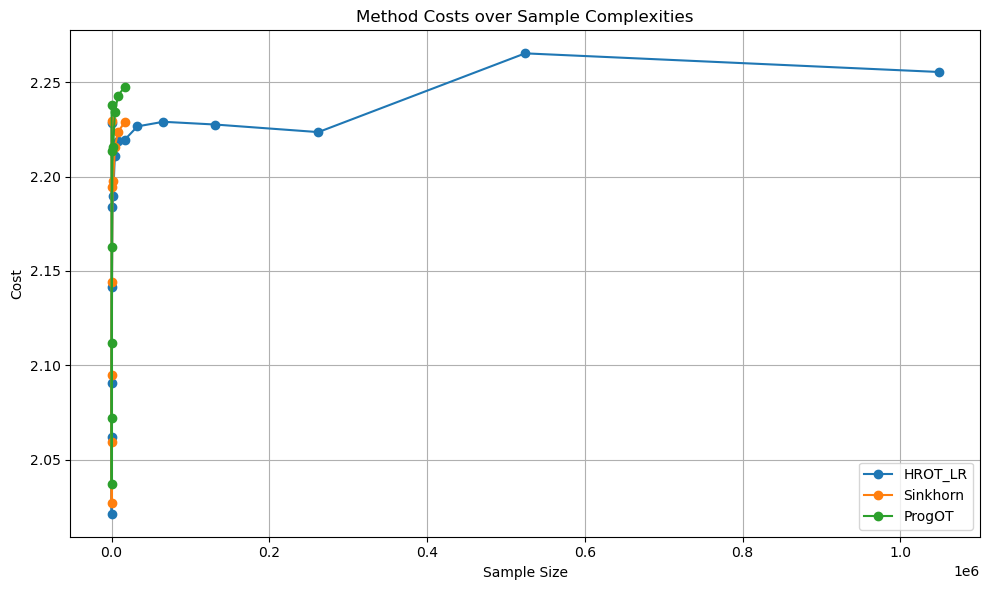

In [12]:
# Plotting the results
plt.figure(figsize=(10, 6))

for method, data in costs.items():
    if data['samples']:
        plt.plot(data['samples'], data['costs'], marker='o', label=method)

plt.xlabel('Sample Size')
plt.ylabel('Cost')
plt.title('Method Costs over Sample Complexities')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

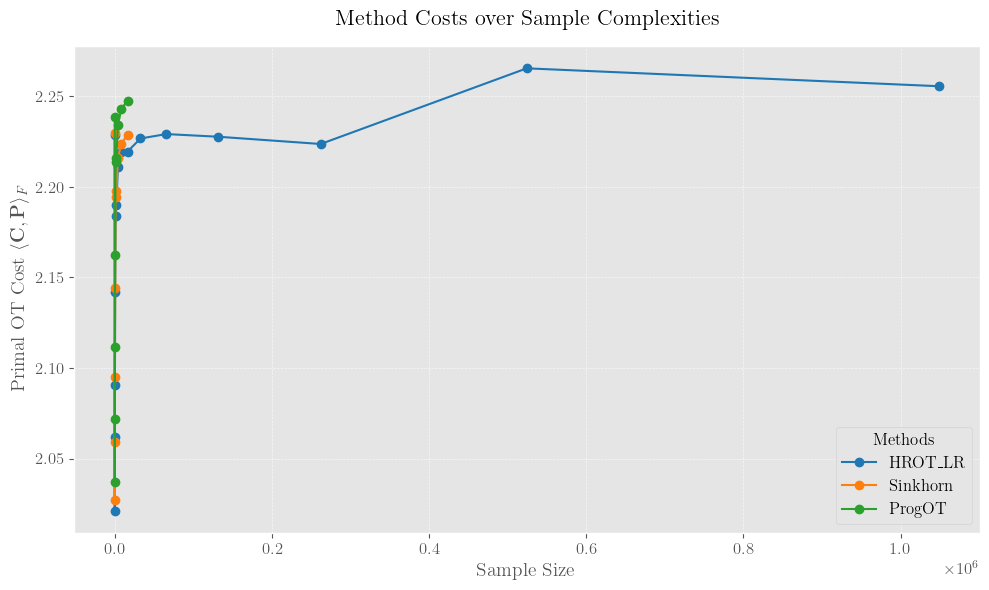

In [20]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "axes.labelsize": 14,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Set a professional style
plt.style.use('ggplot')

# Create figure and axis
plt.figure(figsize=(10, 6))

# Define a color palette
colors = plt.get_cmap('tab10').colors

# Iterate over methods to plot
for idx, (method, data) in enumerate(costs.items()):
    samples = data['samples']
    costs_values = data['costs']
    plt.plot(
        samples, 
        costs_values, 
        marker='o', 
        linestyle='-', 
        color=colors[idx % len(colors)],
        label=method
    )
    '''
    # Annotate each point with its cost value
    for x, y in zip(samples, costs_values):
        plt.annotate(f"{y:.2f}", xy=(x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)'''

# Set labels with LaTeX formatting
plt.xlabel('Sample Size', fontsize=14)
plt.ylabel(r'Primal OT Cost $\langle \mathbf{C}, \mathbf{P} \rangle_{F}$', fontsize=14)

# Set title
plt.title('Method Costs over Sample Complexities', fontsize=16, pad=15)

# Set x-axis ticks to include all unique sample sizes
all_samples = sorted({sample for data in costs.values() for sample in data['samples']})
#plt.xticks(all_samples, fontsize=12, rotation=40)

# Set y-axis tick parameters
plt.yticks(fontsize=12)

# Add legend with larger font size
plt.legend(title='Methods', fontsize=12, title_fontsize=12)

# Add grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.savefig('method_costs_over_samples.png', dpi=300)
plt.show()

In [ ]:
'''
for n in sample_sizes:
    
    print(f'Current sample size: {n}')
    
    X, Y = ret_pts(experiment, n_points = n)
    
    # Define pairwise Dist Mat
    _X, _Y = torch.tensor(np.array(X)).type(torch.DoubleTensor).to(device), \
                        torch.tensor(np.array(Y)).type(torch.DoubleTensor).to(device)
    C = torch.cdist( _X, _Y ) ** p
    rank_schedule = [ K, int( n / K ) ] # Total of (1+K) runs of low-rank OT req'd
    
    # Full-rank cost matrix
    hrot = HR_OT.HierarchicalRefinementOT(C, \
                                  rank_schedule, \
                                  base_rank=1)
    P = hrot.run(return_as_coupling=True)
    cost_hrot = hrot.compute_OT_cost()
    cost_list_hrot.append(cost_hrot)
    #plot_proj(P)

    # Low-rank cost matrix
    hrot_lr = HR_OT.HierarchicalRefinementOT.init_from_point_clouds(_X, _Y, \
                                  rank_schedule, base_rank=1)
    P = hrot_lr.run(return_as_coupling=True)
    #plot_proj(P)
    cost_hrot_lr = hrot_lr.compute_OT_cost()
    cost_list_hrot_lr.append(cost_hrot_lr)
    
    #Sinkhorn Sol'n
    geom = Geometry( C.cpu().numpy() )
    ot_problem = linear_problem.LinearProblem(geom)
    solver = sinkhorn.Sinkhorn()
    ot_solution = solver(ot_problem)
    P_sinkhorn = ot_solution.matrix
    #plot_proj(np.array(P_sinkhorn))
    cost_sink = ( C.cpu().numpy() * P_sinkhorn ).sum()
    cost_list_sink.append(cost_sink)

    # ProgOT Sol'n
    x_train, y_train = X, Y
    alphas = progot.get_alpha_schedule("exp", num_steps=K)
    out = run_progot(X, Y, \
                     cost_fn, alphas=alphas, \
                     epsilons=None)
    P_progOT_default = out.get_output(-1).matrix
    #plot_proj(np.array(P_progOT_default))
    cost_progOT = ( C.cpu().numpy() * P_progOT_default ).sum()
    cost_list_progOT.append(cost_progOT)
    
    print(f'cost HROT: { cost_hrot.item() }, cost HROT-LR: { cost_hrot_lr.item() \
                                                }, cost Sink: { cost_sink }, cost progOT: { cost_progOT }')


'''